## Setup Python and R environment
you can ignore this section

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [12]:
%%R 
df <- read_csv("merged_hmda_with_demo.csv")


Rows: 148917888 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (23): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
%%R 
print(colnames(df))

NULL


In [15]:
# %%R
# library(dplyr)

# # Make sure df is already loaded

# # Filter and add "approved" binary
# df <- df %>%
#   filter(activity_year >= 2015 & activity_year <= 2023) %>%
#   filter(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH")) %>%
#   mutate(
#     approved = ifelse(action_taken == 1, 1, 0)
#   ) %>%
#   select(activity_year, lei, state_code, county_code, action_taken,
#          loan_amount, income, `applicant_race-1`, approved)


In [16]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
%%R

# My commonly used R imports

require('tidyverse')

## Load & Clean Data

👉 Load the data along with the census connectors below (the output of the `connect-to-census.ipynb` notebook) and do any cleanup you'd like to do.

In [4]:
import pandas as pd 
df_hmda = pd.read_csv('hmda_all_years_cleaned.csv')

In [5]:
# def clean_county_code(x):
#     try:
#         return str(int(float(x)))
#     except:
#         return None

# df_hmda['county_code'] = df_hmda['county_code'].apply(clean_county_code)


In [6]:
# df_hmda.sort_values(by='loan_amount', ascending=False).head()

In [7]:
# df_hmda.to_csv('hmda_all_years_cleaned.csv', index=False)

## 👉 Grab Census Data

1. loading the Census API key

In [5]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()


False

In [6]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("CENSUS_API_KEY"))

Loading required package: tidycensus
To install your API key for use in future sessions, run this function with `install = TRUE`.


2. Decide which Census variables you want

    Use <https://censusreporter.org/> to figure out which tables you want. (if censusreporter is down, check out the code in the cell below)

    -   Scroll to the bottom of the page to see the tables.
    -   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

    By default this code loads (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

    - find some other variables that you're also interested in
    - don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
    ).


In [7]:
%%R
library(tidycensus)

us_county_data <- get_acs(
  geography = "county",
  variables = c(
    median_household_income = "B19013_001",
    population = "B01003_001",
    white = "B02001_002",
    black = "B02001_003",
    hispanic = "B03003_003",
    GINI_inequality = "B19083_001",
    employment_rate = "B23025_002"

  ),
  year = 2021,
  survey = "acs5",
  geometry = FALSE,
  cache_table = TRUE
)

# Save to CSV so you can use in Python
write.csv(us_county_data, "county_demographics_raw.csv", row.names = FALSE)


Getting data from the 2017-2021 5-year ACS


In [8]:
df_demo = pd.read_csv("county_demographics_raw.csv")

In [9]:
df_demo["GEOID"] = df_demo["GEOID"].astype(str).str.zfill(5)

In [10]:
def clean_fips(x):
    try:
        return str(int(float(x))).zfill(5)
    except:
        return None

df_hmda["county_code"] = df_hmda["county_code"].apply(clean_fips)


In [11]:
df_hmda["county_code"] = df_hmda["county_code"].apply(
    lambda x: str(int(float(x))).zfill(5) if pd.notnull(x) else None
)

In [12]:
# Pivot
df_demo_wide = df_demo.pivot(index="GEOID", columns="variable", values="estimate").reset_index()

# Rename to match merge key
df_demo_wide = df_demo_wide.rename(columns={"GEOID": "county_code"})

# Fix key in HMDA data to be 5-digit string
df_hmda["county_code"] = df_hmda["county_code"].astype(str).str.zfill(5)
df_demo_wide["county_code"] = df_demo_wide["county_code"].astype(str).str.zfill(5)

# Merge!
df_hmda_merged = df_hmda.merge(df_demo_wide, on="county_code", how="left")


In [13]:
df_hmda_merged.head()

,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,aus-5,denial_reason-1,ffiec_msa_md_median_family_income,GINI_inequality,black,employment_rate,hispanic,median_household_income,population,white
0,2015,NaN,6,06065,NaN,1,1,1,265.0,NaN,...,NaN,NaN,60500.0,0.4524,156255.0,1131857.0,1211185.0,76066.0,2409331.0,1232550.0
1,2015,NaN,27,27147,NaN,6,3,4,151.0,NaN,...,NaN,NaN,63600.0,0.4266,1247.0,19762.0,3033.0,73468.0,37363.0,33644.0
2,2015,NaN,41,41009,NaN,1,1,1,148.0,NaN,...,NaN,NaN,73900.0,0.4079,264.0,25139.0,3007.0,73909.0,52381.0,46948.0
3,2015,NaN,8,08014,NaN,1,3,1,152.0,NaN,...,NaN,NaN,79900.0,0.4085,1032.0,42638.0,9409.0,107570.0,72697.0,60366.0
4,2015,NaN,6,06039,NaN,6,1,4,161.0,NaN,...,NaN,NaN,45800.0,0.4388,4645.0,65719.0,92400.0,66709.0,156304.0,85946.0


In [14]:
#Create a new column for approved loans 
df_hmda_merged['approved'] = df_hmda_merged['action_taken'].apply(lambda x: 1 if x == 1 else 0)


In [15]:
#Create a new column for post-georgefloyd loans
df_hmda_merged['post_georgefloyd'] = df_hmda_merged['activity_year'].apply(lambda x: 1 if x >= 2020 else 0)



In [31]:
# df_1=df_hmda_merged.head(30)
# df_1.to_csv("hmda_merged_with_demo_30.csv", index=False)

In [16]:
df_hmda_merged.to_csv("hmda_merged_with_demo.csv", index=False)

Moving into R 

In [17]:
%%R
df <- read.csv("hmda_merged_with_demo.csv")

In [18]:
%%R 

# Create binary outcome
df <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code)))
  )


In addition: Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `county_code =
  as.character(as.integer(as.numeric(county_code)))`.
Caused by warning:
! NAs introduced by coercion 


In [19]:
# %%R
# install.packages("fixest")

In [20]:
%%R
df <- df %>%
  mutate(post_georgefloyd = ifelse(activity_year >= 2020, 1, 0))


In [25]:
%%R
df_clean <- df %>%
  mutate(
    black_applicant = ifelse(`applicant_race.1` == 3, 1, 0)
  )


In [26]:
# %%R
# colnames(df)


In [27]:
%%R
##Use black applicant number and loan level instead of county % 
library(fixest)

fe_model <- feols(
  approved ~ post_georgefloyd * black_applicant + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

summary(fe_model)
#Before 2020, Black applicants were 4.5 percentage points less likely to be approved compared to non-Black applicants, After 2020, the racial approval gap for Black applicants narrowed slightly by 0.6 points

OLS estimation, Dep. Var.: approved
Observations: 146,240,578
Fixed-effects: county_code: 3,220,  activity_year: 9,  lei: 6,355
Standard-errors: Clustered (county_code) 
                                  Estimate Std. Error    t value   Pr(>|t|)    
black_applicant                  -0.047051   0.003027 -15.544696  < 2.2e-16 ***
employment_rate                   0.000026   1.283718   0.000020 9.9998e-01    
post_georgefloyd:black_applicant  0.009455   0.001182   7.999526 1.7263e-15 ***
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.453457     Adj. R2: 0.164052
                 Within R2: 4.914e-4


NOTE: 2,677,310 observations removed because of NA values (RHS: 2,677,310, Fixed-effects: 2,071,131).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [35]:
%%R
dei_states <- c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH")

df_clean <- df_clean %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% dei_states, 1, 0)
  )


In [36]:
%%R
df_clean <- df_clean %>%
  mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))


In [40]:
%%R
glm_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

summary(glm_dei)


Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()
Error: no more error handlers available (recursive errors?); invoking 'abort' restart
Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()


RInterpreterError: Failed to parse and evaluate line 'glm_dei <- glm(\n  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,\n  data = df_clean,\n  family = binomial()\n)\n\nsummary(glm_dei)\n'.
R error message: 'Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()'
R stdout:
Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()
Error: no more error handlers available (recursive errors?); invoking 'abort' restart

In [41]:
%%R
library(fixest)

feglm_dei <- feglm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income |
    state_code + activity_year + lei,
  data = df_clean,
  family = "logit"
)

summary(feglm_dei)


NOTE: 1/1/209 fixed-effects (5,783,370 observations) removed because of only 0 (or only 1) outcomes.
Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()


RInterpreterError: Failed to parse and evaluate line 'library(fixest)\n\nfeglm_dei <- feglm(\n  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income |\n    state_code + activity_year + lei,\n  data = df_clean,\n  family = "logit"\n)\n\nsummary(feglm_dei)\n'.
R error message: 'Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()'
R stdout:
NOTE: 1/1/209 fixed-effects (5,783,370 observations) removed because of only 0 (or only 1) outcomes.
Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()

In [39]:
%%R
df_black <- df_clean %>%
  filter(black_applicant == 1)


In [34]:
%%R
library(fixest)
library(dplyr)

# Preview column names to confirm
# colnames(df)

df_clean <- df %>%
  # Create variables safely
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),
    black_applicant = ifelse(`applicant_race.1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  # Remove problematic or missing rows
  filter(
    !is.na(approved), !is.na(post_georgefloyd), !is.na(black_applicant),
    !is.na(income), income > 0,
    !is.na(loan_amount), !is.na(debt_to_income),
    !is.na(median_household_income), !is.na(employment_rate),
    !is.na(county_code), !is.na(activity_year)
  )

# Fit logistic regression model
glm_model <- glm(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

# View results
summary(glm_model)


Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()


RInterpreterError: Failed to parse and evaluate line 'library(fixest)\nlibrary(dplyr)\n\n# Preview column names to confirm\n# colnames(df)\n\ndf_clean <- df %>%\n  # Create variables safely\n  mutate(\n    approved = ifelse(action_taken == 1, 1, 0),\n    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),\n    black_applicant = ifelse(`applicant_race.1` == 3, 1, 0),\n    debt_to_income = loan_amount / income\n  ) %>%\n  # Remove problematic or missing rows\n  filter(\n    !is.na(approved), !is.na(post_georgefloyd), !is.na(black_applicant),\n    !is.na(income), income > 0,\n    !is.na(loan_amount), !is.na(debt_to_income),\n    !is.na(median_household_income), !is.na(employment_rate),\n    !is.na(county_code), !is.na(activity_year)\n  )\n\n# Fit logistic regression model\nglm_model <- glm(\n  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income,\n  data = df_clean,\n  family = binomial()\n)\n\n# View results\nsummary(glm_model)\n'.
R error message: 'Error: vector memory limit of 128.0 Gb reached, see mem.maxVSize()'

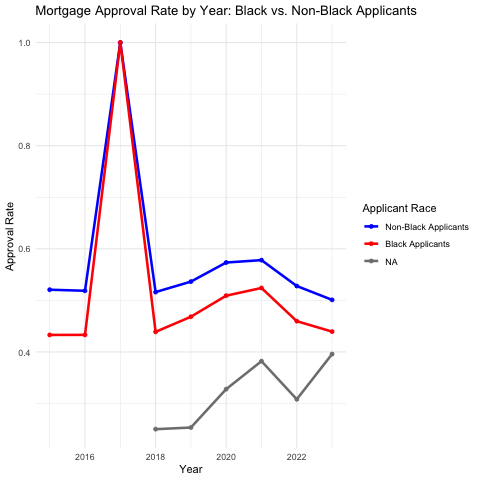

In [33]:
%%R
library(dplyr)
library(ggplot2)

# Step 1: Create flags
df_sample <- df_sample %>%
  mutate(
    black_applicant = ifelse(`applicant_race.1` == 3, 1, 0),
    approved = ifelse(action_taken == 1, 1, 0)
  )

# Step 2: Calculate approval rates by year and race
approval_by_year <- df_sample %>%
  group_by(activity_year, black_applicant) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop")

# Step 3: Plot
ggplot(approval_by_year, aes(x = activity_year, y = approval_rate, color = factor(black_applicant))) +
  geom_line(size = 1.2) +
  geom_point() +
  scale_color_manual(
    values = c("0" = "blue", "1" = "red"),
    labels = c("Non-Black Applicants", "Black Applicants")
  ) +
  labs(
    title = "Mortgage Approval Rate by Year: Black vs. Non-Black Applicants",
    x = "Year",
    y = "Approval Rate",
    color = "Applicant Race"
  ) +
  theme_minimal()


In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


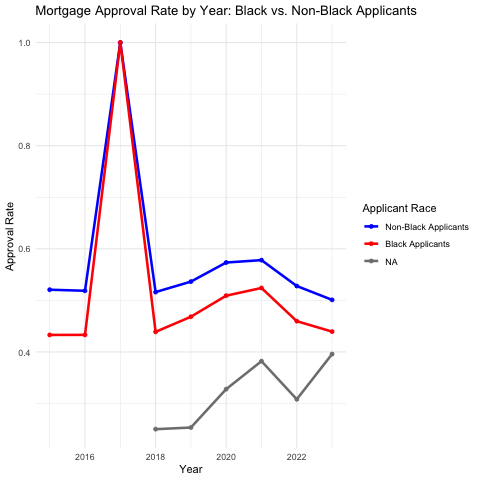

In [31]:
%%R
library(dplyr)
library(ggplot2)

# Step 1: Create flags
df_sample <- df %>%
  mutate(
    black_applicant = ifelse(`applicant_race.1` == 3, 1, 0),
    approved = ifelse(action_taken == 1, 1, 0)
  )

# Step 2: Calculate approval rates by year and race
approval_by_year <- df_sample %>%
  group_by(activity_year, black_applicant) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop")

# Step 3: Plot
ggplot(approval_by_year, aes(x = activity_year, y = approval_rate, color = factor(black_applicant))) +
  geom_line(size = 1.2) +
  geom_point() +
  scale_color_manual(
    values = c("0" = "blue", "1" = "red"),
    labels = c("Non-Black Applicants", "Black Applicants")
  ) +
  labs(
    title = "Mortgage Approval Rate by Year: Black vs. Non-Black Applicants",
    x = "Year",
    y = "Approval Rate",
    color = "Applicant Race"
  ) +
  theme_minimal()


In [ ]:
%%R
library(fixest)
library(dplyr)

# Start from df (raw)
df_clean <- df %>%
  # Create black_applicant dummy
  mutate(
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  # Remove extreme or missing values
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), 
         !is.na(activity_year), !is.na(black_applicant),
         !is.na(income), income > 0,
         !is.na(loan_amount), !is.na(debt_to_income))

# Run model with controls
fe_model_controls <- feols(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income + employment_rate |
    county_code + activity_year + lei,
  data = df_clean
)

# Show results
summary(fe_model_controls)


In [ ]:
%%R
library(fixest)
library(dplyr)

# Start from df (raw)
df_clean <- df %>%
  # Create black_applicant dummy
  mutate(
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  # Remove extreme or missing values
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), 
         !is.na(activity_year), !is.na(black_applicant),
         !is.na(income), income > 0,
         !is.na(loan_amount), !is.na(debt_to_income))

# Run model with controls
glm_model <- glm(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

# Show results
summary(glm_model)


In [13]:
%%R
# Load fixest package
library(fixest)

# Calculate race percentages
df <- df %>%
  mutate(
    pct_black = black / population,
    pct_white = white / population,
    pct_hispanic = hispanic / population
  )

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * pct_black + median_household_income + employment_rate | county_code + activity_year,
  data = df_clean
)

# View results
summary(fe_model)


OLS estimation, Dep. Var.: approved
Observations: 146,258,588
Fixed-effects: county_code: 3,219,  activity_year: 9
Standard-errors: Clustered (county_code) 
                              Estimate Std. Error     t value   Pr(>|t|)    
employment_rate            -0.00000126   0.134997 -0.00000934 9.9999e-01    
post_georgefloyd:pct_black -0.02176838   0.005429 -4.00956038 6.2213e-05 ***
... 2 variables were removed because of collinearity (post_georgefloyd and pct_black)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.484797     Adj. R2: 0.044563
                 Within R2: 7.059e-6


The variables 'post_georgefloyd' and 'pct_black' have been removed because of collinearity (see $collin.var).


In [15]:
%%R
df_clean <- df_clean %>%
  mutate(lei = as.factor(lei))


In [16]:
%%R
# Load fixest package
library(fixest)

# Calculate race percentages
df <- df %>%
  mutate(
    pct_black = black / population,
    pct_white = white / population,
    pct_hispanic = hispanic / population
  )

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * pct_black + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

# View results
summary(fe_model)
#Some banks may be driving racial disparities more than others — when you control for who’s doing the lending, the gap shrinks.


OLS estimation, Dep. Var.: approved
Observations: 110,150,079
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,354
Standard-errors: Clustered (county_code) 
                              Estimate  Std. Error  t value Pr(>|t|) 
pct_black                  4149.439282 48573.29605 0.085426  0.93193 
employment_rate            6154.924223 71807.58989 0.085714  0.93170 
post_georgefloyd:pct_black    0.004392     0.00443 0.991613  0.32146 
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.453057     Adj. R2: 0.170337
                 Within R2: 2.734e-7


NOTE: 36,108,509 observations removed because of NA values (Fixed-effects: 36,108,509).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [18]:
%%R
# Load fixest package
library(fixest)

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * black + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

# View results
summary(fe_model)


OLS estimation, Dep. Var.: approved
Observations: 110,150,079
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,354
Standard-errors: Clustered (county_code) 
                            Estimate   Std. Error   t value Pr(>|t|) 
black                  -1.256893e+04 8.899507e+04 -0.141232  0.88770 
employment_rate         1.206731e+04 8.525426e+04  0.141545  0.88745 
post_georgefloyd:black -5.880000e-09 3.620000e-09 -1.624783  0.10431 
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.453057     Adj. R2: 0.170339
                 Within R2: 1.762e-6


NOTE: 36,108,509 observations removed because of NA values (Fixed-effects: 36,108,509).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [17]:
%%R
library(ggplot2)

# Sample from your cleaned data for plotting (to keep it fast)
plot_data <- df_clean %>%
  filter(!is.na(pct_black), !is.na(post_georgefloyd), !is.na(approved)) %>%
  select(pct_black, post_georgefloyd, employment_rate) %>%
  sample_n(100000)

# Generate predictions from the model
plot_data$predicted <- predict(fe_model, newdata = plot_data)

# Plot: Approval vs. pct_black by pre/post George Floyd
ggplot(plot_data, aes(x = pct_black, y = predicted, color = factor(post_georgefloyd))) +
  geom_smooth(method = "loess", se = FALSE) +
  labs(
    title = "Predicted Approval Rate vs. % Black Residents",
    x = "Share of Black Population (pct_black)",
    y = "Predicted Approval Rate",
    color = "Post George Floyd (1 = 2020+)"
  ) +
  scale_color_manual(labels = c("Pre-2020", "Post-2020"), values = c("blue", "red")) +
  theme_minimal()


Error in predict.fixest(fe_model, newdata = plot_data) : 
  The variable county_code is absent from the 'newdata' but is needed for prediction (it is a fixed-effect variable).


RInterpreterError: Failed to parse and evaluate line 'library(ggplot2)\n\n# Sample from your cleaned data for plotting (to keep it fast)\nplot_data <- df_clean %>%\n  filter(!is.na(pct_black), !is.na(post_georgefloyd), !is.na(approved)) %>%\n  select(pct_black, post_georgefloyd, employment_rate) %>%\n  sample_n(100000)\n\n# Generate predictions from the model\nplot_data$predicted <- predict(fe_model, newdata = plot_data)\n\n# Plot: Approval vs. pct_black by pre/post George Floyd\nggplot(plot_data, aes(x = pct_black, y = predicted, color = factor(post_georgefloyd))) +\n  geom_smooth(method = "loess", se = FALSE) +\n  labs(\n    title = "Predicted Approval Rate vs. % Black Residents",\n    x = "Share of Black Population (pct_black)",\n    y = "Predicted Approval Rate",\n    color = "Post George Floyd (1 = 2020+)"\n  ) +\n  scale_color_manual(labels = c("Pre-2020", "Post-2020"), values = c("blue", "red")) +\n  theme_minimal()\n'.
R error message: "Error in predict.fixest(fe_model, newdata = plot_data) : \n  The variable county_code is absent from the 'newdata' but is needed for prediction (it is a fixed-effect variable)."

In [13]:
%%R
colnames(df)


 [1] "activity_year"                     "lei"                              
 [3] "state_code"                        "county_code"                      
 [5] "derived_dwelling_category"         "action_taken"                     
 [7] "loan_purpose"                      "lien_status"                      
 [9] "loan_amount"                       "property_value"                   
[11] "occupancy_type"                    "income"                           
[13] "applicant_race-1"                  "initially_payable_to_institution" 
[15] "aus-1"                             "aus-2"                            
[17] "aus-3"                             "aus-4"                            
[19] "aus-5"                             "denial_reason-1"                  
[21] "ffiec_msa_md_median_family_income" "GINI_inequality"                  
[23] "black"                             "employment_rate"                  
[25] "hispanic"                          "median_household_income"          

In [12]:
%%R
library(tidyr)

county_demo_wide <- us_county_data %>%
  select(GEOID, NAME, variable, estimate) %>%
  pivot_wider(names_from = variable, values_from = estimate)

# Save the cleaned wide-format CSV
write.csv(county_demo_wide, "county_demographics.csv", row.names = FALSE)


In [14]:
df_hmda_merged_2 = df_hmda_merged [
    (df_hmda_merged ['loan_purpose'] == 1) &
    (df_hmda_merged ['occupancy_type'] == 1) &
    (df_hmda_merged ['lien_status'] == 1) &
    (df_hmda_merged ['derived_dwelling_category'].isin([
        'Single Family (1-4 Units):Site-Built',
        'Single Family (1-4 Units):Manufactured'
    ]))
]


In [14]:
df_hmda_merged.sort_values(by='loan_amount', ascending=False).head()


,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,aus-5,denial_reason-1,ffiec_msa_md_median_family_income,GINI_inequality,black,employment_rate,hispanic,median_household_income,population,white
93584888,2020,549300DAUXQ2DCY4H838,MA,25017.0,Single Family (1-4 Units):Site-Built,4,31,1,5.000006e+11,NaN,...,NaN,10.0,118800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131203215,2022,549300VQUTI5IU7GXT57,GA,13121.0,Single Family (1-4 Units):Site-Built,5,1,1,2.400003e+11,NaN,...,NaN,10.0,95700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147964425,2023,254900JXCS783CPF1D02,NY,00nan,Single Family (1-4 Units):Site-Built,3,4,1,2.323232e+11,NaN,...,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89005608,2020,549300ZGTXNHL5BKQZ27,NaN,00nan,Single Family (1-4 Units):Site-Built,4,1,1,2.000003e+11,NaN,...,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126719826,2022,549300NJVKCDJA5YC939,AZ,4015.0,Single Family (1-4 Units):Manufactured,4,31,1,4.568360e+10,NaN,...,NaN,10.0,63100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
